In [41]:
import torch
import pickle as pkl
from tqdm import tqdm
import os
import datetime
import numpy as np
import glob
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import  OneHotEncoder
import pandas as pd
from sklearn import svm
import time
import matplotlib.pyplot as plt
import sklearn.model_selection as skl_ms
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

## Import data

In [17]:
output_T2_info = np.load("./patient_outcome.npy", allow_pickle=True).item()

In [18]:
output_T2_info.get('16')

['3.3', '0.78125', '0.78125', '3', '1', '74', 'No']

In [19]:
outcome = np.load("./result3.npy", allow_pickle=True)

### Create DataFrame

In [148]:
resultFilePaths = np.load("./resultFilePaths.npy")
result0 = np.load(resultFilePaths[0], allow_pickle=True)
columns_names = ['PatientID']+['Outcome','gender', 'weight']+list(result0.keys())[22:]
df = pd.DataFrame(columns=columns_names)
df = df.set_index(['PatientID'])

In [149]:
def selectFeaturesFromResult(resultFilePath):
    res = np.load(resultFilePath, allow_pickle=True)
    values = [float(value) for value in list(res.values())[22:] ]
    return values

In [150]:
def selectLabelFromOutcome(PatientID, outcomeFile):
    r = outcomeFile.get(str(PatientID))
    label = r[-1]
    basicFeatures = r[-3:-1]
    return [label]+[float(i) for i in basicFeatures]

In [151]:
for path in resultFilePaths:
    PatientID = int(path.split("/")[-2][3:])
    outcomeOfPatient = selectLabelFromOutcome(PatientID, output_T2_info)
    values = selectFeaturesFromResult(path)
    v = outcomeOfPatient + values
#     print(list(map(type, v)))
    df.loc[PatientID] =  v

In [152]:
df.gender = df.gender.astype(float)
df.weight = df.weight.astype(float)

In [153]:
df.head()

,Outcome,gender,weight,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,...,log-sigma-3-0-mm-3D_glcm_Imc1,log-sigma-3-0-mm-3D_glcm_Imc2,log-sigma-3-0-mm-3D_glcm_Idm,log-sigma-3-0-mm-3D_glcm_Idmn,log-sigma-3-0-mm-3D_glcm_Id,log-sigma-3-0-mm-3D_glcm_Idn,log-sigma-3-0-mm-3D_glcm_InverseVariance,log-sigma-3-0-mm-3D_glcm_MaximumProbability,log-sigma-3-0-mm-3D_glcm_SumEntropy,log-sigma-3-0-mm-3D_glcm_SumSquares
PatientID,,,,,,,,,,,,,,,,,,,,,
1,Light,0.0,74.0,0.137332,0.020878,4.331391,207.465202,211.200564,30.277375,231.404235,...,-0.495738,0.781897,0.942994,0.993293,0.942994,0.977198,0.114011,0.550751,1.389324,0.247221
102,Complete,0.0,77.0,0.191051,0.028080,6.659925,237.173898,279.044799,49.206199,279.752122,...,-0.588316,0.775965,0.966875,0.996103,0.966875,0.986750,0.066250,0.731557,1.065144,0.181750
103,Tangible,0.0,90.0,0.271264,0.036345,7.857014,216.177564,261.000000,66.001894,261.275716,...,-0.538426,0.786132,0.956211,0.994848,0.956211,0.982484,0.087578,0.750952,1.269011,0.203576
11,Complete,1.0,65.0,0.229518,0.026919,2.189601,81.340930,89.105352,21.086741,92.817065,...,-0.617782,0.854906,0.957176,0.991435,0.957176,0.978588,0.085648,0.610492,1.430337,0.272906
12,Tangible,0.0,76.0,0.197865,0.035252,7.405435,210.069338,207.021738,50.224496,198.161550,...,-0.525181,0.741154,0.959395,0.991879,0.959395,0.979698,0.081209,0.722927,1.101705,0.182736


### Save dataframe

In [154]:
df.to_csv("data.csv")

In [ ]:
# df.columns.values

In [129]:
columns = []
for col in df.columns.values:
    columns.append(col.replace("_", " "))

### Data splitting

#### Drop the no response patient

In [155]:
df = df[df.index!=16]

### Balance dataset

In [359]:
# max_size = df['Outcome'].value_counts().max()
# lst = [df]
# for class_index, group in df.groupby('Outcome'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# dataframe_balanced = pd.concat(lst)

In [439]:
# df = dataframe_balanced

In [156]:
I = np.random.choice(df.shape[0],size=df.shape[0],replace=False)

df_shuffled = df.iloc[I]

In [307]:
# trainI = np.arange(0, int(df_shuffled.shape[0]*0.6))
# testI = np.arange(df_shuffled.shape[0]*0.6, df_shuffled.shape[0]*0.8)
# devI = np.arange(df_shuffled.shape[0]*0.8, df_shuffled.shape[0]*1)

In [157]:
testI= np.array([1,8,13,20,40,44,49,55])
testIndex = df_shuffled.index.isin(testI)


In [158]:
test = df_shuffled.loc[testIndex]
train_val = df_shuffled.loc[~testIndex]

In [159]:
trainI = np.arange(0, int(train_val.shape[0]*0.8))
devI = np.arange(int(train_val.shape[0]*0.8), int(train_val.shape[0]) )

In [160]:

train = df_shuffled.iloc[trainI]
# test = df_shuffled.iloc[testI]

dev = df_shuffled.iloc[devI]

featues_columns = df_shuffled.columns.values[1:]

X_train = train[featues_columns]
Y_train = train['Outcome']
X_test = test[featues_columns]
Y_test = test['Outcome']
X_dev = dev[featues_columns]
Y_dev = dev['Outcome']

le = preprocessing.LabelEncoder()
le.fit(df_shuffled['Outcome'])

Y_train = le.transform(Y_train)
Y_test  = le.transform(Y_test)
Y_dev  = le.transform(Y_dev)

In [161]:
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(24, 256)
(8, 256)
(6, 256)


In [162]:
le.classes_

array(['Complete', 'Light', 'Tangible'], dtype=object)

In [163]:
X_train_val = train_val[featues_columns]
Y_train_val = train_val['Outcome']
Y_train_val = le.transform(Y_train_val)

In [164]:
df.Outcome.describe()

count           38
unique           3
top       Tangible
freq            20
Name: Outcome, dtype: object

<AxesSubplot:>

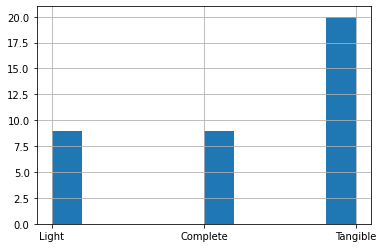

In [165]:
df.Outcome.hist()

## K-fold cross validation

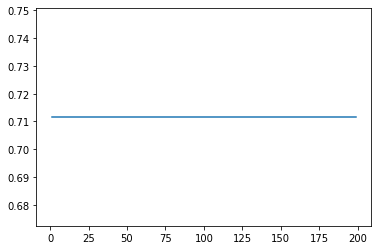

In [469]:
X = df_shuffled[featues_columns]
y = df_shuffled['Outcome']
n_fold = 3
cv = skl_ms.KFold(n_splits=n_fold, random_state=2,shuffle=True);
K = np.arange(1,200)
misclassification = np.zeros(len(K))

for train_index, val_index in cv.split(X):
  x_train, x_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]
  for j,k in enumerate(K):
    model = svm.SVC(decision_function_shape='ovo',class_weight='balanced')
#     model = XGBClassifier(num_class=3, objective='multi:softmax')
    model.fit(x_train,y_train)
    prediction = model.predict(x_val)
    misclassification[j] += np.mean(prediction!=y_val)

misclassification /= n_fold

for i, mis in enumerate(misclassification):
  if i==0:
    min_i = i;
    min_e = misclassification[0];
  elif min_e >= mis:
    min_e = mis
    min_i = i 



plt.plot(K,misclassification)
plt.show()
  

In [470]:
print(min_e)
print(min_i)

0.7115384615384616
198


### Feature selection: ANOVA

In [116]:
anova = SelectPercentile(f_classif)

## SVM

In [118]:
model_svm = svm.SVC(decision_function_shape='ovo')
model_svm.fit(X_train_val, Y_train_val.ravel())

SVC(decision_function_shape='ovo')

In [119]:
Y_pred_test_svm = model_svm.predict(X_test)
accuracy_test_svm = accuracy_score(Y_test.ravel(), Y_pred_test_svm)
print("Prediction",Y_pred_test_svm)
print(accuracy_test_svm)

Prediction [2 2 2 2 2 2 2 2]
0.5


In [120]:
print(metrics.classification_report(Y_test, Y_pred_test_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8



c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost

In [167]:
# X_train_val

In [171]:
model_xgboost = XGBClassifier(num_class=3, objective='multi:softmax')
model_xgboost.fit(X_train_val[selected_features], Y_train_val.ravel())

XGBClassifier(num_class=3, objective='multi:softprob')

In [175]:
Y_pred_test = model_xgboost.predict(X_test[selected_features])
accuracy_test = accuracy_score(Y_test.ravel(), Y_pred_test)
print(accuracy_test)

NameError: name 'selected_features' is not defined

In [174]:
print(metrics.classification_report(Y_test, Y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.33      0.50      0.40         4

    accuracy                           0.25         8
   macro avg       0.11      0.17      0.13         8
weighted avg       0.17      0.25      0.20         8



c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tune the hyper-parameters of XGBoostClassifier

In [149]:
def modelfit(alg, x_train, y_train, x_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg = alg.fit(x_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    
#     Predict on testing data:
    dtest_predictions = alg.predict(x_test)
    dtest_predprob = alg.predict_proba(x_test)[:,1]
    print('Accuracy Score (Test): %f' % metrics.accuracy_score(y_test, dtest_predictions))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp[feat_imp>1].plot(kind='bar', title='Feature Importances')
#     print()
    plt.ylabel('Feature Importance Score')
    return feat_imp[feat_imp>1]

In [179]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        scale_pos_weight=1,
        num_class=3, 
        objective='multi:softmax',
        seed=27)

### Feature selection


Model Report
Accuracy : 1
Accuracy Score (Test): 0.250000


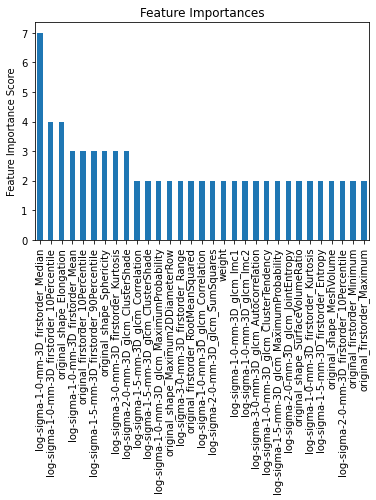

In [180]:
xx = modelfit(xgb1, X_train_val, Y_train_val, X_test, Y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

In [247]:
selected_features = xx.index.values
print(len(selected_features ))

31


In [174]:
param_test1 = {
    'max_depth':range(1,10,2),
    'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  nthread=4, scale_pos_weight=1, seed=27, num_class=3, objective='multi:softmax',), 
                       param_grid = param_test1, scoring='balanced_accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_val[selected_features], Y_train_val)

c:\python37\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=140, nthread=4, num_class=3,
                                     objective='multi:softmax', seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': range(1, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='balanced_accuracy')

In [ ]:
gsearch1.cv_results_

In [176]:
gsearch1.best_score_

0.5666666666666667

In [177]:
gsearch1.best_params_

{'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1}

In [178]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## Neural network

In [106]:
import torch 
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
from tensorboardX import SummaryWriter

In [60]:
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

In [107]:
x_train = X_train[selected_features].values
y_train = Y_train
x_test = X_test[selected_features].values
y_test = Y_test
x_dev = X_dev[selected_features].values

y_dev = Y_dev

dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).long()),
                     shuffle = True, batch_size = 2)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_dev).float(),torch.tensor(y_dev).long()),
                     shuffle = False, batch_size = 2)
dl_test = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).long()),
                     shuffle = False, batch_size = 2)

In [108]:
print(x_test.shape)
print(x_train.shape)
print(x_dev.shape)

(8, 26)
(24, 26)
(6, 26)


In [109]:
def create_net():
    net = nn.Sequential(
        nn.Linear(31, 128),
        nn.ReLU(),
        nn.Dropout(0.75),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )
    return net

In [110]:
net = create_net()
print(net)
optimizer = torch.optim.Adam(params=net.parameters(),lr = 1e-2)
from torch.optim.lr_scheduler import CosineAnnealingLR, \
    CosineAnnealingWarmRestarts, StepLR, MultiStepLR, ExponentialLR
metric_name = "accuracy"

Sequential(
  (0): Linear(in_features=26, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.75, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=3, bias=True)
)


In [111]:
epochs = 100
dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)
scheduler = CosineAnnealingLR(optimizer, 10, eta_min=1e-3, last_epoch=-1)
log_path = "C:/Users/nangu/OneDrive - Uppsala universitet/ComputationalScienceProjectData/nn_history"
writer = SummaryWriter(log_dir=log_path + '/nn' + time.strftime('%m-%d_%H.%M', time.localtime()))
for epoch in range(1,epochs+1):  

    net.train()
    loss_sum = 0.0
    acc_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1):
    
        optimizer.zero_grad()

        predictions = net(features)
        loss = F.cross_entropy(predictions,labels)
#         metric = metrics.accuracy_score(predictions,labels)
        
        true = labels.data.cpu()
        predic = torch.max(predictions.data, 1)[1].cpu()
        acc = metrics.accuracy_score(true, predic)
        
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        acc_sum += acc.item()

#     scheduler.step()
    net.eval()

    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    
    loss_total = 0
    for val_step, (features,labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            val_predictions = net(features)
            val_loss = F.cross_entropy(val_predictions,labels)
            loss_total += val_loss
            val_true = labels.data.cpu()
            val_predic = torch.max(val_predictions.data, 1)[1].cpu()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, val_predic)
    dev_acc = metrics.accuracy_score(labels_all, predict_all)
    
    dev_loss =  loss_total / len(dl_valid)
    info = (epoch, loss_sum/len(dl_train), acc_sum/len(dl_train), 
            dev_loss, dev_acc)
    dfhistory.loc[epoch-1] = info
    
    print(("\nEPOCH = %d, loss = %.5f,"+ metric_name + \
          "  = %.5f, val_loss = %.5f, "+"val_"+ metric_name+" = %.5f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#     print("\n"+"=========="*8 + "%s"%nowtime)
    writer.add_scalar("loss/train", loss_sum/len(dl_train), epoch)
    writer.add_scalar("loss/dev", dev_loss, epoch)
    writer.add_scalar("acc/train", acc_sum/len(dl_train), epoch)
    writer.add_scalar("acc/dev", dev_acc, epoch)
writer.close()
print('Finished Training...')

Start Training...
================================================================================2021-01-09 10:20:54

EPOCH = 1, loss = 3.96258,accuracy  = 0.37500, val_loss = 0.94279, val_accuracy = 0.66667

EPOCH = 2, loss = 3.47997,accuracy  = 0.37500, val_loss = 1.52160, val_accuracy = 0.66667

EPOCH = 3, loss = 2.19583,accuracy  = 0.33333, val_loss = 1.16636, val_accuracy = 0.16667

EPOCH = 4, loss = 2.09613,accuracy  = 0.20833, val_loss = 1.17912, val_accuracy = 0.16667

EPOCH = 5, loss = 1.36598,accuracy  = 0.33333, val_loss = 0.90337, val_accuracy = 0.66667

EPOCH = 6, loss = 1.43604,accuracy  = 0.54167, val_loss = 0.99997, val_accuracy = 0.66667

EPOCH = 7, loss = 0.85851,accuracy  = 0.66667, val_loss = 1.06272, val_accuracy = 0.33333

EPOCH = 8, loss = 1.59512,accuracy  = 0.41667, val_loss = 0.93171, val_accuracy = 0.66667

EPOCH = 9, loss = 1.03550,accuracy  = 0.50000, val_loss = 0.95457, val_accuracy = 0.66667

EPOCH = 10, loss = 1.19146,accuracy  = 0.50000, val_loss = 1.2

In [112]:
predict_all_test = np.array([], dtype=int)
labels_all_test = np.array([], dtype=int)
test_loss_sum = []
for val_step, (features,labels) in enumerate(dl_test, 1):
    with torch.no_grad():
        predictions = net(features)
        test_loss = F.cross_entropy(predictions,labels)
        test_loss_sum.append(test_loss.item())
        test_true = labels.data.cpu()
        test_predic = torch.max(predictions.data, 1)[1].cpu()
        labels_all_test = np.append(labels_all_test, labels)
        predict_all_test = np.append(predict_all_test, test_predic)

In [113]:
test_acc = metrics.accuracy_score(labels_all_test, predict_all_test)
print(test_acc)
print(np.mean(test_loss_sum))

0.5
8.553807020187378


In [114]:
report = metrics.classification_report(labels_all_test, predict_all_test)

c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8



In [525]:
labels_all_test, predict_all_test

(array([2, 2, 1, 0, 2, 1, 0, 2], dtype=int64),
 array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))

In [526]:
Y_test, Y_pred_test

(array([2, 2, 1, 0, 2, 1, 0, 2]), array([2, 2, 2, 2, 0, 0, 2, 2]))

In [527]:
Y_test, Y_pred_test_svm

(array([2, 2, 1, 0, 2, 1, 0, 2]), array([2, 2, 2, 2, 2, 2, 2, 2]))

In [528]:
ensemble = []
for i in range(len(Y_pred_test)):
    prdiction_en = Y_pred_test[i] if Y_pred_test[i]== predict_all_test[i] else predict_all_test[i]
    ensemble.append(prdiction_en)
